# Calibrate with flat calibration pattern with known absolute pose

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from dt_apriltags import Detector

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, mat2quat

In [2]:
def compute_transform_from_point_correspondences(points_source, points_target):
    """
    Compute 3D translation and rotation from point correspondences.
    
    Uses SVD-based method to find optimal rigid transformation that maps
    points_source to points_target.
    
    Args:
        points_source: Nx3 numpy array of source points
        points_target: Nx3 numpy array of target points
        
    Returns:
        R: 3x3 rotation matrix
        t: 3x1 translation vector
    """
    # Convert to numpy arrays
    points_source = np.array(points_source)
    points_target = np.array(points_target)
    
    # Ensure we have at least 3 points
    if points_source.shape[0] < 3:
        raise ValueError("Need at least 3 point correspondences")
    
    # Compute centroids
    centroid_source = np.mean(points_source, axis=0)
    centroid_target = np.mean(points_target, axis=0)
    
    # Center the points
    points_source_centered = points_source - centroid_source
    points_target_centered = points_target - centroid_target
    
    # Compute the covariance matrix H
    H = points_source_centered.T @ points_target_centered
    
    # Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)
    
    # Compute rotation matrix
    R = Vt.T @ U.T
    
    # Handle reflection case (det(R) = -1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    
    # Compute translation
    t = centroid_target - R @ centroid_source
    
    return R, t


def compute_reprojection_error(points_source, points_target, R, t):
    """
    Compute reprojection error for a given transformation.
    
    Args:
        points_source: Nx3 numpy array of source points
        points_target: Nx3 numpy array of target points
        R: 3x3 rotation matrix
        t: 3x1 translation vector
        
    Returns:
        mean_error: Mean Euclidean distance error
        max_error: Maximum Euclidean distance error
        errors: Array of individual errors
    """
    points_source = np.array(points_source)
    points_target = np.array(points_target)
    
    # Transform source points
    points_transformed = (R @ points_source.T).T + t
    
    # Compute errors
    errors = np.linalg.norm(points_transformed - points_target, axis=1)
    
    return np.mean(errors), np.max(errors), errors


def euler_from_quaternion(q_wxyz):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)
    """
    w = q_wxyz[0]
    x = q_wxyz[1]
    y = q_wxyz[2]
    z = q_wxyz[3]

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = np.atan2(t0, t1)
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = np.asin(t2)
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = np.atan2(t3, t4)
    return roll_x, pitch_y, yaw_z # in radians


new detection:
. Tag ID: 0

new detection:
. Tag ID: 1

new detection:
. Tag ID: 2

new detection:
. Tag ID: 3

new detection:
. Tag ID: 4


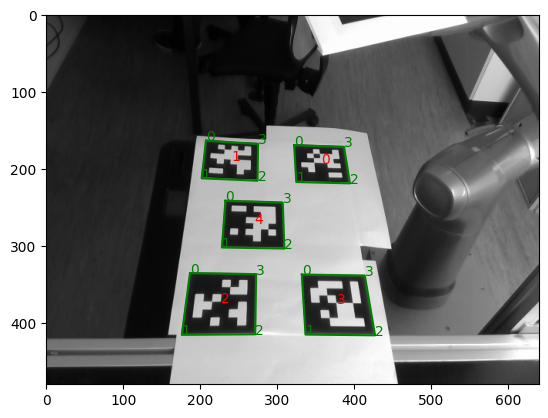

In [ ]:
data_root = '../../../data/realsense/calibration/calibdata_2025_12_11-13_19_46'

apriltag_family = 'tag36h11' # AprilTag family used in the calibration
tagsize = 0.10  # size of the AprilTag side in meters

calibration_file = data_root+'/handeye_calibration.json'
calibration_config_file = data_root+'/handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)
    
detector = Detector(families=apriltag_family,
                    nthreads=1,
                    quad_decimate=1.0,
                    quad_sigma=0.0,
                    refine_edges=1,
                    decode_sharpening=0.25,
                    debug=0)

frame, gray, detections = load_and_detect(frame_count=0, data_root=data_root, detector=detector, tagsize=tagsize)

# 3d reconstruction (from https://github.com/AprilRobotics/apriltag?tab=readme-ov-file#pose-estimation):
# "The coordinate system has the origin at the camera center. The z-axis points from the camera 
# center out the camera lens. The x-axis is to the right in the gray taken by the camera, and 
# y is down. The tag's coordinate frame is centered at the center of the tag. From the viewer's 
# perspective, the x-axis is to the right, y-axis down, and z-axis is into the tag."

plt.imshow(gray, cmap='gray');

for detection in detections:
    print("\nnew detection:")
    print(". Tag ID:", detection.tag_id)
    #print(". Center:", detection.center)
    #print(". Corners:", detection.corners)
    #print(". Pose R:", detection.pose_R)
    #print(". Pose t:", detection.pose_t.T)

    plt.text(detection.center[0], detection.center[1], str(detection.tag_id), color='red')
    plt.plot([detection.corners[i%4][0] for i in range(5)],
             [detection.corners[i%4][1] for i in range(5)], 'g-')
    for i in range(4):
        plt.text(detection.corners[i][0],
                detection.corners[i][1], str(i), color='green')
    


In [4]:
P_Base = np.array([[  0.05+0.28,  -0.35, 0.77],   # corner 0
                   [  0.22+0.28,  -0.35, 0.77],   # corner 1
                   [  0.22+0.28,  -0.05, 0.77],   # corner 2
                   [  0.05+0.28,  -0.05, 0.77],   # corner 3
                   [ 0.175+0.28,  -0.20, 0.77]])  # center

P_cam = np.array([detections[0].pose_t.flatten(),  # corner 0
                  detections[1].pose_t.flatten(),  # corner 1
                  detections[2].pose_t.flatten(),  # corner 2
                  detections[3].pose_t.flatten(),  # corner 3
                  detections[4].pose_t.flatten()]) # center 

assert P_cam.shape == P_Base.shape, "Point correspondence shapes do not match!"

print("\nPoint correspondences (Base -> Camera):")
for i in range(P_Base.shape[0]):
    print(f"Base point {i}: {P_Base[i]} -> Camera point {i}: {P_cam[i]}")


Point correspondences (Base -> Camera):
Base point 0: [ 0.33 -0.35  0.77] -> Camera point 0: [ 0.05479266 -0.09193683  0.89661636]
Base point 1: [ 0.5  -0.35  0.77] -> Camera point 1: [-0.11505648 -0.09625951  0.87559658]
Base point 2: [ 0.5  -0.05  0.77] -> Camera point 2: [-0.10348344  0.13210981  0.67805176]
Base point 3: [ 0.33 -0.05  0.77] -> Camera point 3: [0.06595102 0.13720808 0.69627432]
Base point 4: [ 0.455 -0.2    0.77 ] -> Camera point 4: [-0.06503951  0.02068572  0.78558556]


In [5]:
R, t = compute_transform_from_point_correspondences(P_Base, P_cam)
print("\nComputed Transformation:")
print("Rotation R:\n", R)
print("Translation t:\n", t)

mean_error, max_error, errors = compute_reprojection_error(P_Base, P_cam, R, t)
print(f"\nReprojection Error:\n Mean Error: {mean_error:.6f} m\n Max Error: {max_error:.6f} m")

print("\nPose of center marker:")
print("Rotation R:\n", detections[4].pose_R)
print("Translation t:\n", detections[4].pose_t.T)


Computed Transformation:
Rotation R:
 [[-0.99404425  0.04144761  0.10078756]
 [-0.03503895  0.75418274 -0.65572911]
 [-0.10319065 -0.65535524 -0.74823873]]
Translation t:
 [0.31859667 0.69093089 1.27514734]

Reprojection Error:
 Mean Error: 0.002401 m
 Max Error: 0.003526 m

Pose of center marker:
Rotation R:
 [[ 0.03819823 -0.99556983 -0.08591625]
 [ 0.75997317 -0.02688333  0.64939823]
 [-0.648831   -0.09009991  0.75557947]]
Translation t:
 [[-0.06503951  0.02068572  0.78558556]]


In [6]:
T_cam_base = np.eye(4)
T_cam_base[0:3, 0:3] = R
T_cam_base[0:3, 3] = t

T_base_cam = np.eye(4)
T_base_cam[0:3, 0:3] = R.T
T_base_cam[0:3, 3] = -R.T @ t

print("\nTrafo camera to base:\n", T_cam_base)
print("\nTrafo base to camera:\n", T_base_cam)


Trafo camera to base:
 [[-0.99404425  0.04144761  0.10078756  0.31859667]
 [-0.03503895  0.75418274 -0.65572911  0.69093089]
 [-0.10319065 -0.65535524 -0.74823873  1.27514734]
 [ 0.          0.          0.          1.        ]]

Trafo base to camera:
 [[-0.99404425 -0.03503895 -0.10319065  0.47249195]
 [ 0.04144761  0.75418274 -0.65535524  0.30138126]
 [ 0.10078756 -0.65572911 -0.74823873  1.37506754]
 [ 0.          0.          0.          1.        ]]


In [7]:
calib_quat_wxyz = mat2quat(T_base_cam[0:3, 0:3])
calib_translation = T_base_cam[0:3, 3]

print("T_base_cam=", T_base_cam)
print("Quaternion=", calib_quat_wxyz)
print("Translation=", calib_translation) 

roll, pitch, yaw = euler_from_quaternion(calib_quat_wxyz)
print(f"Euler angles (radians): ", [float(roll), float(pitch), float(yaw)])

if data_root:
    save_calibration(calibration_file, calibration_config, calib_quat_wxyz.tolist(), calib_translation.tolist(), 
                     [0], data_root)

T_base_cam= [[-0.99404425 -0.03503895 -0.10319065  0.47249195]
 [ 0.04144761  0.75418274 -0.65535524  0.30138126]
 [ 0.10078756 -0.65572911 -0.74823873  1.37506754]
 [ 0.          0.          0.          1.        ]]
Quaternion= [ 0.05454301 -0.00171365 -0.93494194  0.35057908]
Translation= [0.47249195 0.30138126 1.37506754]
Euler angles (radians):  [-2.4219909286998806, -0.10095898142484848, 3.0999208477409406]
